##### Imports / Keys

In [4]:
import pandas as pd
import pandas_ta as ta

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import requests
from configparser import ConfigParser
from io import BytesIO
parser = ConfigParser()
_ = parser.read('notebook.cfg')

nasdaq_auth_key = parser.get('my_api', 'nasd_key')
quant_auth_key = parser.get('my_api', 'quant_key')
alpha_auth_key = parser.get('my_api', 'alpha_key')

### Main Daily Historical AlphaVantage Function (Stock, Price, Returns, Technical Indicators)

In [3]:
def alpha_historical_daily(ticker, start_date, end_date):
    # Alpha vantage API request for daily adjusted prices
    token = alpha_auth_key
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&outputsize=full&symbol={ticker}&interval=5min&apikey={token}&datatype=csv'
    r = requests.get(url)

    # Converting from bytes to pandas dataframe : https://stackoverflow.com/questions/47379476/how-to-convert-bytes-data-into-a-python-pandas-dataframe
    df_daily = pd.read_csv(BytesIO(r.content))
    
    # Creating Sorted Datetime index based on inputted date range
    df_daily.set_index('timestamp', inplace=True)
    df_daily = df_daily[df_daily.index >= start_date]
    df_daily = df_daily[df_daily.index <= end_date]
    df_daily.index = pd.to_datetime(df_daily.index)
    df_daily.sort_index(inplace=True)
    df_daily.drop(columns=['dividend_amount', 'split_coefficient'], inplace=True)
    
    # Engineering Cumulative Return and Total Position Column for $100,000 Investment
    daily_returns = df_daily['adjusted_close'] / df_daily['adjusted_close'].iloc[0]      
    df_daily['cum_return'] = daily_returns
    
    # Position column to track performane (Using $100,000 as initial outlay investment)
    allocation = 100_000
    df_daily['position'] = allocation * df_daily['cum_return']
    
    # Engineering Moving Average 10 & 20 days columns
    df_daily['MA10'] = df_daily['adjusted_close'].rolling(10).mean()
    df_daily['MA20'] = df_daily['adjusted_close'].rolling(20).mean()
    
    # Engineering RSI-14 Indicator and 70/30 Bands
    ticker_rsi = df_daily.ta.rsi(close='adjusted_close', length=14, signal_indicators=True, xa=70, xb=30)
    
    # Creating Final DataFrame 
    ticker_final = pd.concat([df_daily.reset_index(drop=True),ticker_rsi.reset_index(drop=True)], axis=1)
    
    # Finalizing with a new Cumulative Return % column
    ticker_final['cum_return_percent'] = ticker_final.cum_return -1
    
    # Setting Datetime index 
    ticker_final.index = df_daily.index
    return ticker_final

#### Testing Function (alpha_historical_daily) on Facebook 

In [3]:
FB = alpha_historical_daily('FB', '2021-01-01', '2021-12-10')
print(FB.shape)
FB.head()

(238, 14)


,open,high,low,close,adjusted_close,volume,cum_return,position,MA10,MA20,RSI_14,RSI_14_A_70,RSI_14_B_30,cum_return_percent
timestamp,,,,,,,,,,,,,,
2021-01-04,274.78,275.00,265.2000,268.94,268.94,15106113,1.000000,100000.000000,NaN,NaN,NaN,0,0,0.000000
2021-01-05,268.29,272.40,268.2111,270.97,270.97,9871557,1.007548,100754.815200,NaN,NaN,NaN,0,0,0.007548
2021-01-06,262.00,267.75,260.0100,263.31,263.31,24354149,0.979066,97906.596267,NaN,NaN,NaN,0,0,-0.020934
2021-01-07,265.90,271.61,264.7800,268.74,268.74,15789756,0.999256,99925.633970,NaN,NaN,NaN,0,0,-0.000744
2021-01-08,268.31,268.95,263.1800,267.57,267.57,18528251,0.994906,99490.592697,NaN,NaN,NaN,0,0,-0.005094


### Single Stock Price Chart Analysis Graph

In [5]:
ticker1 = 'FB'
start_date = '2021-01-01'
end_date = '2021-12-09'
token = alpha_auth_key

In [8]:
def ticker_analysis(ticker, start_date, end_date):
    # Calling alpha_historical_daily function to get all ticker data
    ticker1_final = alpha_historical_daily(ticker, start_date, end_date)
      
    # Creating Plotly Subplot Using The Two Ticker DataFrames
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.05, 
                    row_heights=[0.25,0.1,0.1])

    #Ticker 1 details
    # Adding Line Graph
    fig.add_trace(go.Scatter(
        x=ticker1_final.index, y=ticker1_final['adjusted_close'], 
        line=dict(width=2), name=f'{ticker}', visible='legendonly'), row=1, col=1)
    # Adding Candlestick Graph
    fig.add_trace(go.Candlestick(
    x=ticker1_final.index, open=ticker1_final['open'],
    high=ticker1_final['high'], low=ticker1_final['low'],
    close=ticker1_final['close'], name=f'{ticker}'), row=1, col=1)
    #adding Moving Average 10day line
    fig.add_trace(go.Scatter(
        x=ticker1_final.index, y=ticker1_final['MA10'], 
        line=dict(color='white', width=1), name=f'{ticker} MA(10)'))
    #adding Moving Average 20day line                
    fig.add_trace(go.Scatter(
        x=ticker1_final.index, y=ticker1_final['MA20'], 
        line=dict(color='yellow', width=1), name=f'{ticker} MA(20)'))
    #adding volume indicator
    fig.add_trace(go.Bar(
        x=ticker1_final.index, y=ticker1_final['volume'],
        marker_color = 'LightSkyBlue', showlegend=True, name=f'{ticker} Vol.'), row=2, col=1)
    #adding RSI indicator 
    fig.add_trace(go.Scatter(
        x=ticker1_final.index, y=ticker1_final['RSI_14'],
        line=dict(color='#EF8820', width=2), showlegend=True, name=f'{ticker} RSI'), row=3, col=1)
    
    #setting RSI range from 0-100 as standard practice for this indicator
    fig.update_yaxes(
        range=[-10, 110], row=3, col=1)
    fig.add_hline(
        y=0, col=1, row=3, line_color="#C3BEB9", line_width=2)
    fig.add_hline(
        y=100, col=1, row=3, line_color="#C3BEB9", line_width=2)
    #adding overbought/oversold lines for RSI 30/70 levels
    fig.add_hline(
        y=40, col=1, row=3, line_color='#93a1a1', line_width=1.5, line_dash='dash')
    fig.add_hline(
        y=90, col=1, row=3, line_color='#93a1a1', line_width=1.5, line_dash='dash')

    fig.update_layout(
        height=600, width=1000, showlegend=True, xaxis_rangeslider_visible=False,
        paper_bgcolor=None, template='plotly_dark', legend_orientation="v",
        title=dict(
            text=f"{ticker1} ({start_date} / {end_date})",
            y=0.975, x=0.5, xanchor='center', yanchor='top'),
        legend=dict(
            yanchor="top", y=1.05, xanchor="left", x=0.0225, font={'size':12}),
        font=dict(
            family="Gotham Narrow, monospace", size=16, color="#A4A4A4"),
        margin=go.layout.Margin(
            l=60, r=25, b=30, t=60)) 

    fig.update_layout(xaxis_range=[f'{start_date}',f'{end_date}']) 
    fig.update_xaxes(tickformat="%b\n%Y", dtick='M1')

    #updating sublot yaxis labels, used as resource : https://stackoverflow.com/questions/58849925/plotly-how-to-apply-different-titles-for-each-different-subplots
    fig['layout']['yaxis']['title']='Price'
    fig['layout']['yaxis2']['title']='Volume'
    fig['layout']['yaxis3']['title']='RSI-14'    

    return fig.show()

#### Testing Function (ticker_analysis) on Facebook

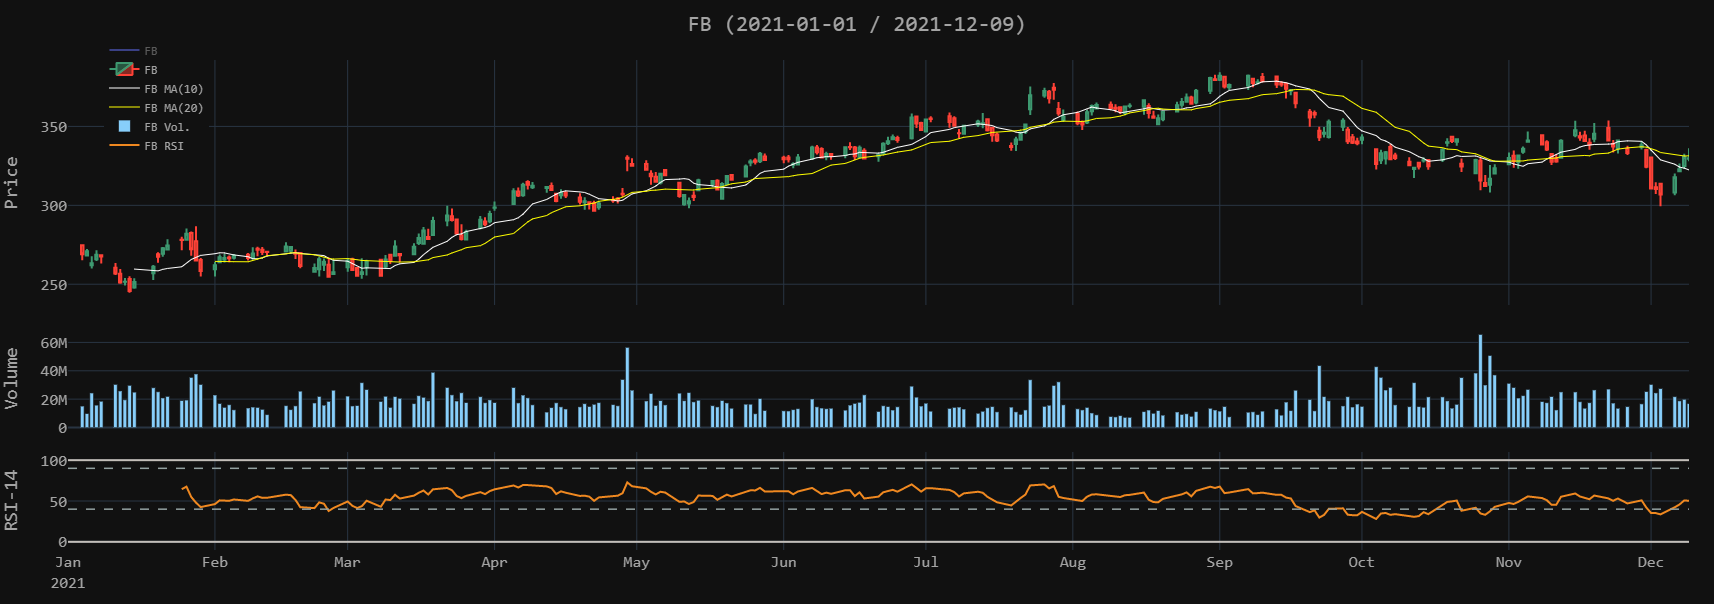

In [9]:
ticker = 'FB'
start_date = '2021-01-01'
end_date = '2021-12-09'
ticker_analysis(ticker, start_date, end_date)

### Single Stock Cumulative Return Analysis Graph

In [7]:
def ticker_cum_return(ticker, start_date, end_date):
    # Calling alpha_historical_daily function to get all ticker data
    ticker1_final = alpha_historical_daily(ticker, start_date, end_date)
   
    fig = px.line(
        ticker1_final, x=ticker1_final.index, y='cum_return_percent',
        labels={
            'index': "", 'cum_return': 'Cumulative Return (%)'})
               
    fig.update_layout(
        title={
            'text': f'{ticker} ({start_date} / {end_date})', 'y':0.95, 'x':0.5,
            'xanchor': 'center', 'yanchor': 'top'})

    fig.update_layout(
        height=600, width=1000, showlegend=True, 
        xaxis_rangeslider_visible=False,
        font=dict(
            family="Gotham Narrow, monospace", size=16, color="#A4A4A4"))

    fig.update_layout(margin=go.layout.Margin(
        l=30,r=30, b=10, t=60),
        paper_bgcolor=None, template='plotly_dark')
    fig.update_layout(xaxis_range=[f'{start_date}',f'{end_date}'], xaxis_visible=True) 
    fig.update_xaxes(tickformat="%b\n%Y", dtick='M1')
    fig.update_yaxes(tickformat=".2%")
    
    fig.add_hline(
        y=0, col=1, row=1, line_color='#6EB7F8', line_width=2, line_dash='dash')
    
    fig.add_trace(go.Indicator(
    align = 'center', mode = "number+delta", value = ticker1_final['position'][-1], name = 'Performance', visible = True,
    title = {
        "text": "$100k Investment<br><span style='font-size:0.8em;color:gray'></span><br><span style='font-size:0.8em;color:yellow'>",
        'font':{
        'size':20,
        'color':'yellow'}, 'align':'center'},
    delta = {
        'reference': 100_000, 'relative': True, 'valueformat':'.2%',
        'font':{
        'size':40}},
    number = {
        'prefix': "$", 
        'font':{
        'size':40}}))
#    domain = {
#        'x': [1, 1], 'y': [1, 1]}))
    
    fig['layout']['yaxis']['title']='Cumulative Return %'
    fig['layout']['xaxis']['title']=''

    return fig.show()

#### Testing Function (ticker_cum_return) on Facebook

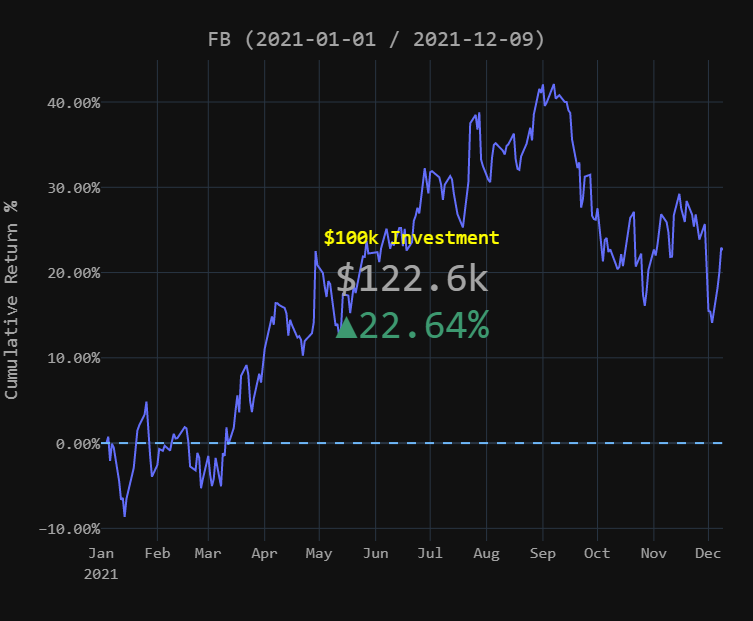

In [8]:
ticker = 'FB'
start_date = '2021-01-01'
end_date = '2021-12-09'
ticker_cum_return(ticker, start_date, end_date)

### Stock Comparison Cumulative Return Analysis Graph

In [14]:
def ticker_cum_return_comp(ticker1, ticker2, start_date, end_date):
    # Calling alpha_historical_daily function to get all ticker data
    ticker1_final = alpha_historical_daily(ticker1, start_date, end_date)
    ticker2_final = alpha_historical_daily(ticker2, start_date, end_date)
    ticker3_final = alpha_historical_daily('SPY', start_date, end_date)    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
    x=ticker1_final.index, y=ticker1_final['cum_return_percent'], 
    line=dict(width=2), name=f'{ticker1}', visible=True))
    fig.add_trace(go.Scatter(
    x=ticker2_final.index, y=ticker2_final['cum_return_percent'], 
    line=dict(width=2), name=f'{ticker2}', visible=True))
    fig.add_trace(go.Scatter(
    x=ticker3_final.index, y=ticker3_final['cum_return_percent'], 
    line=dict(width=2), name='SPY', visible='legendonly'))    
    
    fig.update_layout(
        title={
            'text': f'{ticker1} | {ticker2} ({start_date} / {end_date})', 'y':0.95, 'x':0.5,
            'xanchor': 'center', 'yanchor': 'top'})

    fig.update_layout(
        height=600, width=1000, showlegend=True, 
        xaxis_rangeslider_visible=False,
        font=dict(
            family="Gotham Narrow, monospace", size=16, color="#A4A4A4"))

    fig.update_layout(margin=go.layout.Margin(
        l=30,r=30, b=10, t=60),
        paper_bgcolor=None, template='plotly_dark')
    fig.update_layout(xaxis_range=[f'{start_date}',f'{end_date}'], xaxis_visible=True) 
    fig.update_xaxes(tickformat="%b\n%Y", dtick='M1')
    fig.update_yaxes(tickformat=".2%")
    
    fig.add_hline(
        y=0, col=1, row=1, line_color='#6EB7F8', line_width=2, line_dash='dash')
    
    
    fig['layout']['yaxis']['title']='Cumulative Return %'
    fig['layout']['xaxis']['title']=''

    return fig.show()

#### Testing Function (ticker_cum_return_comp) on Facebook vs. Blackstone

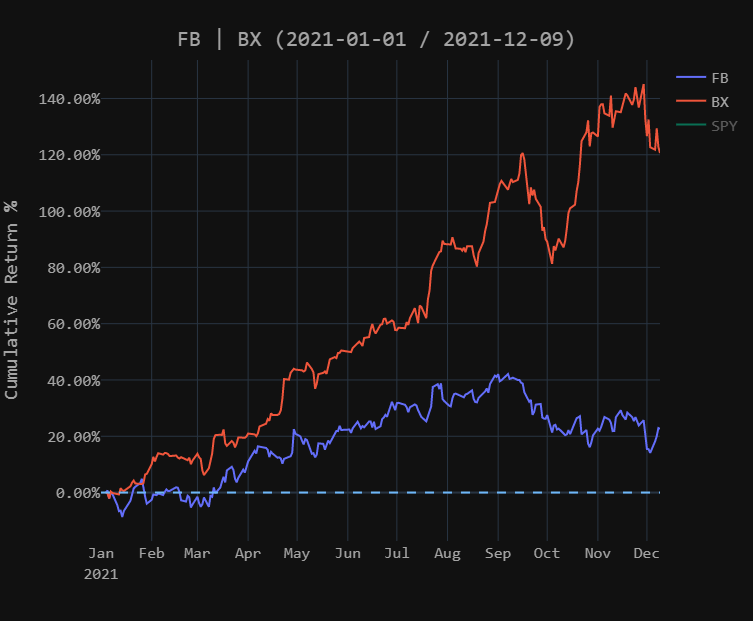

In [15]:
ticker1 = 'FB'
ticker2 = 'BX'
start_date = '2021-01-01'
end_date = '2021-12-09'
ticker_cum_return_comp(ticker1, ticker2, start_date, end_date)

## Stock Comparison Price Graph

In [12]:
def ticker_comparison(ticker1, ticker2, start_date, end_date):
    # Pulling 14 year historical daily price data for ticker 1, saving to df_ticker1 DataFrame
    ticker1_final = alpha_historical_daily(ticker1, start_date, end_date)
    ticker2_final = alpha_historical_daily(ticker2, start_date, end_date)
    
    # Creating Plotly Graph Using The Two Ticker DataFrames
    fig = make_subplots(specs=[[{'secondary_y': True}]])


    #Ticker 1 details
    fig.add_trace(go.Scatter(
        x=ticker1_final.index, y=ticker1_final['adjusted_close'], 
        line=dict(width=2), name=f'{ticker1}'))
    # Adding candlestick chart                   
    fig.add_trace(go.Candlestick(
        x=ticker1_final.index, open=ticker1_final['open'],
        high=ticker1_final['high'], low=ticker1_final['low'],
        close=ticker1_final['close'], name=f'{ticker1}', visible='legendonly'))

    #Ticker 2 details
    # Adding line graph
    fig.add_trace(go.Scatter(
        x=ticker2_final.index, y=ticker2_final['adjusted_close'], 
        line=dict(width=2), name=f'{ticker2}'), secondary_y=True)
    # Adding candlestick graph              
    fig.add_trace(go.Candlestick(
        x=ticker1_final.index, open=ticker2_final['open'],
        high=ticker2_final['high'], low=ticker2_final['low'],
        close=ticker2_final['close'], name=f'{ticker2}', visible='legendonly'), secondary_y=True)

    # Customizing Graph layout and axes
    fig.update_layout(
        height=600, width=1000, showlegend=True, xaxis_rangeslider_visible=True,
        paper_bgcolor=None, template='plotly_dark', legend_orientation="h",
        title=dict(
            text=f"{ticker1} | {ticker2} ({start_date} / {end_date})",
            y=0.975, x=0.5, xanchor='center', yanchor='top'),
        legend=dict(
            yanchor="top", y=1.05, xanchor="left", x=0.0225, font={'size':12}),
        font=dict(
            family="Gotham Narrow, monospace", size=16, color="#A4A4A4"),
        margin=go.layout.Margin(
            l=60, r=25, b=30, t=60)) 

    fig.update_layout(xaxis_range=[f'{start_date}',f'{end_date}']) 
    fig.update_xaxes(tickformat="%b\n%Y", dtick='M1')
    fig.update_yaxes(title_text=f"{ticker1} Price", secondary_y=False)
    fig.update_yaxes(title_text=f"{ticker2} Price", secondary_y=True)

    return fig.show()

#### Testing Function (ticker_comparison) on Facebook vs. Blackstone

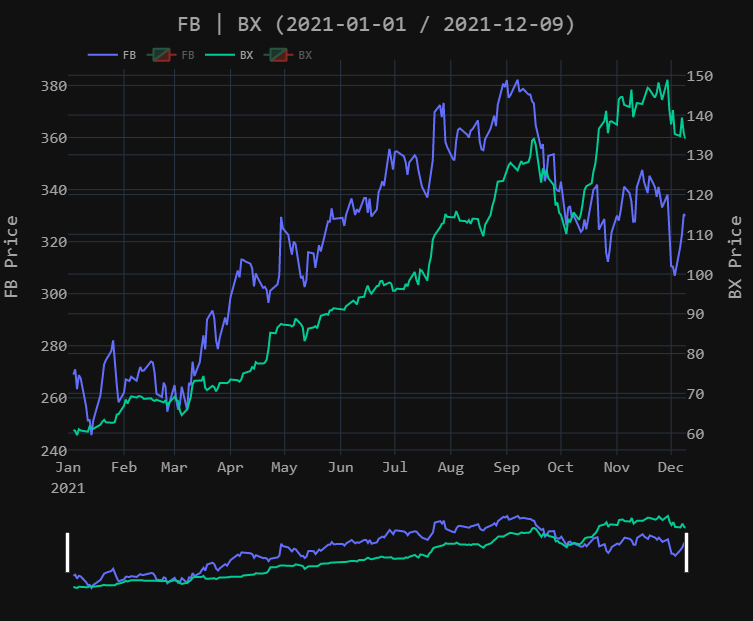

In [13]:
ticker1 = 'FB'
ticker2 = 'BX'
start_date = '2021-01-01'
end_date = '2021-12-09'
ticker_comparison(ticker1, ticker2, start_date, end_date)